<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Exercises for the course<br>
        <b>Machine Learning for Data Science</b><br>
    Winter Semester 2024/25
    </p>
</td>
<td style='background-color:white'>
    G. Montavon<br>
    Institute of Computer Science<br>
    <b>Department of Mathematics and Computer Science</b><br>
    Freie Universität Berlin
</td>
</tr>
</table>

<br>
<center>
    <h1>Exercise Sheet 9 (programming part)</h1>
</center>
<br>

We will investigate the use of discriminants derived from probability models, and compare them to the Fisher linear discriminant presented in the previous lectures. Recall that the Fisher discriminant finds a projection that minimizes the sum-of-squares of data points with their respective class means and that maximizes the difference between projected means. An implementation of the Fisher discriminant is provided in the cell below. It is a class with two functions, one for fitting the model from the datasets of the two classes, and one for predicting the discriminant scores associated to some dataset given as input.

In [1]:
import numpy,numpy.linalg

class FDA:
    
    def __init__(self):
        pass
    
    def fit(self,X1,X2):
        d = X1.shape[1]
        m1 = X1.mean(axis=0)
        m2 = X2.mean(axis=0)
        X = numpy.concatenate([X1,X2])
        Si = numpy.linalg.inv(numpy.cov(X.T))
        self.w = Si.dot(m2-m1)
        return self
        
    def predict(self,X):
        return numpy.dot(X,self.w)

## Exercise 3: Implementing a Gaussian-Based Discriminant (10 + 30 + 10 P)

In this exercise, we will apply discriminant analyses to the wine dataset accessible via sklearn. Specifically, we would like to analyze to which extent a particular cultivar (the one associated to index 0 in the dataset), can be identified from a reduced set of compositional features: Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols. The code below extracts the data for the desired task.

In [2]:
import sklearn,sklearn.datasets
X,T = sklearn.datasets.load_wine(return_X_y=True)

X = X[:,4:8]   # extract compositional features of interest
X = X - X.mean(axis=0)
X = X / X.std(axis=0)
T = 1.0*(T==0) # indicator function of the cultivar of interest

XN = X[T==0] # negative examples
XP = X[T==1] # positive examples

Before implementing the discriminant analysis, we would like to perform some initial data analysis. First, we perform a two-dimensional PCA of the data, which we render as a scatter plot, where each point is color-coded in orange (pos) if it belongs to the given cultivar and in blue (neg) if it is not the case.

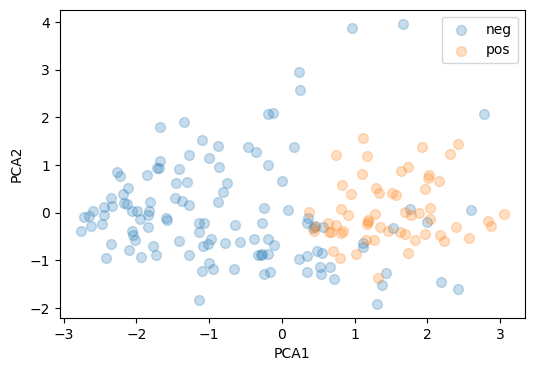

In [3]:
import sklearn.decomposition
Xpca = sklearn.decomposition.PCA(n_components=2).fit_transform(X)

%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(*Xpca[T==0].T,alpha=0.25,label='neg',s=50)
plt.scatter(*Xpca[T==1].T,alpha=0.25,label='pos',s=50)
plt.legend()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

From this PCA plot, we can observe some specificies of the distribution, that suggest that a linear discriminant between the two classes may be suboptimal. In particular, the covariance structure of both classes appears different, specifically, the distribution of positive instances appears to have less variance than the negative one. To verify this visual insight, we would like to measure quantitatively the total variance of the two distributions.

**(a)** Print the total variance of the distribution of each class.

In [19]:
def printTotalVariance(XN, XP):
    # Total variance as the trace of the covariance matrix
    var_neg = numpy.trace(numpy.cov(XN, rowvar=False))
    var_pos = numpy.trace(numpy.cov(XP, rowvar=False))
    
    print(f"Total variance for negative class: {var_neg:.3f}")
    print(f"Total variance for positive class: {var_pos:.3f}")

printTotalVariance(XN, XP)

Total variance for negative class: 3.720
Total variance for positive class: 1.316


These quantitative measurements corroborate our initial visual insight. The observation that the two distributions have different covariance structures motivates the use of a more powerful discriminant than the Fisher discriminant. Here, we will consider the Gaussian-based discriminant which was presented during the lecture, and whose equations are below. Specifically, one computes the log likelihood ratio of two Gaussians distributions representing each class

\begin{align*}
\newcommand{\x}{\boldsymbol{x}}
\newcommand{\bmu}{\boldsymbol{\mu}}
p_1(\x) &\sim \mathcal{N}(\bmu_1,\Sigma_1)\\
p_2(\x) &\sim \mathcal{N}(\bmu_2,\Sigma_2)
\end{align*}

and then define the discriminant to be the log-probability ratio between the data likelihoods associated to each class:

\begin{align*}
f(\x) &= \log p_1(\x) - \log p_2(\x)\\
&= \frac12 (\x - \bmu_1)^\top \Sigma_1^{-1} (\x - \bmu_1) - \frac12 (\x - \bmu_2)^\top \Sigma_2^{-1} (\x - \bmu_2) + \text{cst.}
\end{align*}

**(b)** Implement the quadratic discriminant's fit and predict functions (you can ignore the constant term).

In [15]:
import numpy

class QDA:
    def fit(self, X1, X2):
        """
        Fits the QDA model to the two classes X1 and X2.
        Calculates the means and covariance matrices for both classes.
        """
        self.mu1 = X1.mean(axis=0)  # Mean of class 1
        self.mu2 = X2.mean(axis=0)  # Mean of class 2
        self.cov1 = numpy.cov(X1.T)  # Covariance matrix for class 1
        self.cov2 = numpy.cov(X2.T)  # Covariance matrix for class 2
        
        # Precompute inverse covariance matrices
        self.cov1_inv = numpy.linalg.inv(self.cov1)
        self.cov2_inv = numpy.linalg.inv(self.cov2)
        return self

    def predict(self, X):
        """
        Predicts the log-likelihood ratio of the input X for the two classes.
        """
        def log_likelihood(X, mu, cov_inv):
            diff = X - mu
            return -0.5 * numpy.sum((diff @ cov_inv) * diff, axis=1)

        # Compute log-likelihoods
        ll1 = log_likelihood(X, self.mu1, self.cov1_inv)
        ll2 = log_likelihood(X, self.mu2, self.cov2_inv)
        
        # Return the log-likelihood ratio
        return ll2 - ll1

In [16]:
fda = FDA().fit(XN,XP)
qda = QDA().fit(XN,XP)

We now produce histograms of the projected distributions for both discriminant models.

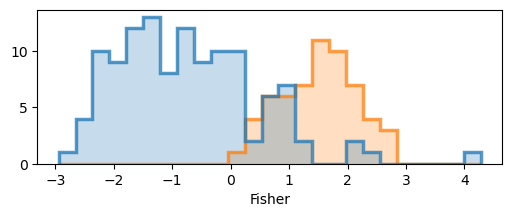

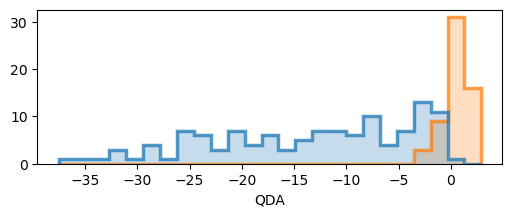

In [17]:
def hist(ZN,ZP,name):
    plt.figure(figsize=(6,2))
    plt.hist([ZN,ZP],color=['C0','C1'],bins=25,alpha=0.25,histtype='stepfilled')
    plt.hist([ZN,ZP],color=['C0','C1'],bins=25,alpha=0.75,histtype='step',lw=2.5)
    plt.xlabel(name)
    plt.show()

hist(fda.predict(XN),fda.predict(XP),'Fisher')
hist(qda.predict(XN),qda.predict(XP),'QDA')

Unlike the Fisher discriminant, the quadratic discriminant does not reduce within-class variance. However, it appears that the two class are fairly well separable if considering separability as being on one or the other side of some threshold value. To verify this, we will use the area under the ROC curve (AUROC) metric, which quantifies this and which is readily implemented by the function `sklearn.metrics.roc_auc_score`.


**(c)** Compute the areas under the ROC curves associated to both discriminants. You can make use of the corresponding function from sklearn for that purpose.

In [18]:
from sklearn.metrics import roc_auc_score

def printAUROC(fda, qda, X, T):
    fda_scores = fda.predict(X)
    qda_scores = qda.predict(X)
    auroc_fda = roc_auc_score(T, fda_scores)
    auroc_qda = roc_auc_score(T, qda_scores)
    print(f"AUROC-Fisher: {auroc_fda:.3f}")
    print(f"AUROC-QDA: {auroc_qda:.3f}")

printAUROC(fda, qda, X, T)

AUROC-Fisher: 0.942
AUROC-QDA: 0.988


We observe that the quadratic discriminant performs better than the simpler Fisher model. Overall, our analysis have allowed to clearly demonstrate the predictability of the wine cultivar from the given set of wine compositional features.